In [62]:
from project.thermal import conventional_heating_final, stat_heating_consumption, HDD, conventional_energy_3uses ,VENTILATION_TYPES
from project.utils import make_plot
from project.input.param import generic_input
import pandas as pd
import math

# Estimation of EPC and energy need
The Notebook is looking how to reduce the error of the primary energy need estimations functions used in Res-IRF when applied to the Profeel database. The output of the Notebook is the profeel database enriched by EPC estimated with Res-IRF functions used for merging household data in data_matching's Notebook.
1. Introduction
    * First estimations with thermal functions
    * Comparisons of the ratio_surface with the aggregated from Res-IRF
2. Validation: primary energy estimations
    * Estimation with the ratio_surface of Res-IRF
    * Standard estimation: what will do Res-IRF when running this database (actual ratio_surface and no ventilation)
    * Estimation with the actual ratio_surface but adding ventilation thermal transmittance values
    * Estimation weighted by the energy mix
    * Investigating some comparisons

## Introduction

In [63]:
buildings = pd.read_csv('building_stock_profeel_detailed.csv', index_col=['Class', 'Housing type'])
buildings = buildings[buildings['Heating system'] != 'RCU']
ratio_surface = buildings.loc[:,'Ratio_surface_Wall':'Ratio_surface_Window']
ratio_surface = ratio_surface.rename(columns={'Ratio_surface_Floor': "Floor", 'Ratio_surface_Wall': "Wall", 'Ratio_surface_Roof': "Roof", 'Ratio_surface_Window': "Windows"})

In [64]:
'''efficiency = pd.read_csv('project/input/efficiency.csv')
efficiency = to_dict(efficiency)'''

"efficiency = pd.read_csv('project/input/efficiency.csv')\nefficiency = to_dict(efficiency)"

In [65]:
# For the moment I'm not calling the csv
efficiency = {'Electricity-Performance boiler': 0.95,
           'Natural gas-Standard boiler': 0.6,
          'Natural gas-Performance boiler': 0.76,
              'Wood fuel-Standard boiler': 0.6
           }


heating_eff = buildings['Heating system'].replace(efficiency).set_axis(buildings.index)
buildings = pd.concat((buildings, heating_eff.rename('Efficiency')), axis=1)

In [66]:
# Could change the csv directly
translate = {'Natural ventilation': 'Ventilation naturelle', 'CMV': 'VMC SF auto et VMC double flux',
                     'CMV hygro': 'VMC SF hydrogérable'}

buildings['Ventilation'] = buildings['Ventilation'].replace(translate)
buildings['Ventilation'] = buildings['Ventilation'].replace(VENTILATION_TYPES)


In [67]:
conventional_heating_final(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'])

Class  Housing type 
MI-1   Single-family    543.096229
MI-2   Single-family    524.206233
MI-3   Single-family    615.586544
MI-4   Single-family    484.211094
MI-5   Single-family    545.120274
MI-6   Single-family    404.712123
MI-7   Single-family    388.491595
MI-8   Single-family    520.462310
MI-9   Single-family    435.804522
MI-10  Single-family    583.250820
MI-11  Single-family    338.532247
MI-12  Single-family    149.893476
MI-13  Single-family    173.627260
MI-14  Single-family    116.936507
MI-15  Single-family     92.657724
MI-16  Single-family    117.672179
MI-17  Single-family     78.857016
LC1    Multi-family     122.435851
LC2    Multi-family     109.553944
LC3    Multi-family     207.775433
LC4    Multi-family     192.921960
LC5    Multi-family     156.210845
LC6    Multi-family     157.006354
LC7    Multi-family     218.284814
LC8    Multi-family     170.668903
LC9    Multi-family     243.902313
LC10   Multi-family     333.287609
LC11   Multi-family     274.248369

In [68]:
stat_heating_consumption(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], buildings['Efficiency'], ratio_surface, HDD)

Class  Housing type 
MI-1   Single-family    688.904416
MI-2   Single-family    664.688494
MI-3   Single-family    766.153931
MI-4   Single-family    617.601242
MI-5   Single-family    694.459819
MI-6   Single-family    535.333797
MI-7   Single-family    506.276081
MI-8   Single-family    668.794806
MI-9   Single-family    568.024862
MI-10  Single-family    736.346141
MI-11  Single-family    448.226415
MI-12  Single-family    200.718399
MI-13  Single-family    237.475529
MI-14  Single-family    152.076934
MI-15  Single-family    118.537762
MI-16  Single-family    156.667911
MI-17  Single-family    105.848773
LC1    Multi-family     175.191995
LC2    Multi-family     158.161535
LC3    Multi-family     288.503058
LC4    Multi-family     272.651496
LC5    Multi-family     229.353904
LC6    Multi-family     221.518599
LC7    Multi-family     307.354997
LC8    Multi-family     241.423590
LC9    Multi-family     334.724891
LC10   Multi-family     480.796276
LC11   Multi-family     402.507047

##### Comparing the surface ratio of Profeel's database with the aggregated ones in Res-IRF

In [69]:
temp = pd.concat((buildings['Stock buildings'], ratio_surface), axis=1)
av_ratio_surface = (temp['Stock buildings'] * temp.loc[:, 'Wall':].T).T
av_ratio_surface = ((av_ratio_surface.groupby('Housing type').sum()).T/temp.groupby('Housing type')['Stock buildings'].sum()).T.sort_index(ascending=False)
av_ratio_surface

,Wall,Floor,Roof,Windows
Housing type,,,,
Single-family,1.167578,0.350053,1.057829,0.183813
Multi-family,0.496068,0.067430,0.163829,0.306495


In [70]:
agg_ratio_surface = generic_input['ratio_surface']
agg_ratio_surface

,Wall,Floor,Roof,Windows
Housing type,,,,
Single-family,1.42,0.09375,0.77,0.17
Multi-family,0.78,0.03500,0.29,0.19


## Validation: primary energy estimations

#### Taking the aggregate surface ratio used in Res-IRF and no ventilation

In [71]:
buildings = buildings.set_index('Heating system', append=True)
epc, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], agg_ratio_surface, buildings['Efficiency'], buildings.index)
energy_epc_surface = pd.concat((buildings, epc.rename('calculated_epc'), energy_primary.rename('primary_energy_estimated')), axis=1)

#### Standard Res-IRF estimation: Without taking ventilation into account, but with surface

In [72]:
epc, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'], buildings.index)
energy_epc_std = pd.concat((buildings, epc.rename('calculated_epc')), axis=1)
#energy_epc_std = pd.concat((buildings, epc.rename('calculated_epc'), energy_primary.rename('primary_energy_estimated')), axis=1)
buildings['primary_energy_estimated'] = energy_primary
buildings['estimation_error'] = buildings['primary_energy_estimated'] - buildings['primary energy']

#### Taking ventilation into account

In [73]:
epc, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'], buildings.index, air_rate=buildings['Ventilation'])
energy_epc_vent = pd.concat((buildings, epc.rename('calculated_epc'), energy_primary.rename('primary_energy_estimated_vent')), axis=1)
energy_epc_vent['vent_estimation_error'] = energy_epc_vent['primary_energy_estimated_vent'] - energy_epc_vent['primary energy']

In [75]:
stock_main = buildings.copy()
stock_main = stock_main.reset_index('Heating system')
stock_other_carriers = stock_main.replace(to_replace={'Electricity-Performance boiler': 'Natural gas-Standard boiler', 'Natural gas-Standard boiler': 'Electricity-Performance boiler', 'Natural gas-Performance boiler': 'Electricity-Performance boiler', 'Wood fuel-Standard boiler': 'Electricity-Performance boiler'}).copy()

# Creating the weight column which gather the share of the selected energy carrier in the heating system, for the main or the others energy carriers
for idx in stock_main.index:
    if stock_main.loc[idx,'Heating system'] in {'Natural gas-Standard boiler',  'Natural gas-Performance boiler', 'Wood fuel-Standard boiler'}:
        stock_main.loc[idx, 'weights 1'] = stock_main.loc[idx, 'Fossil fuel share']
    else:
        stock_main.loc[idx, 'weights 1'] = stock_main.loc[idx, 'Electric fuel share']

for idx in stock_other_carriers.index:
    if stock_other_carriers.loc[idx,'Heating system'] in {'Natural gas-Standard boiler',  'Natural gas-Performance boiler', 'Wood fuel-Standard boiler'}:
        stock_other_carriers.loc[idx, 'weights 2'] = stock_other_carriers.loc[idx, 'Fossil fuel share']
    else:
        stock_other_carriers.loc[idx, 'weights 2'] = stock_other_carriers.loc[idx, 'Electric fuel share']

# Estimation of annual energy needs for the main energy carrier case
stock_main = stock_main.set_index('Heating system', append=True)
_, stock_main['energy_primary_estimate'] = conventional_energy_3uses(stock_main['Wall'], stock_main['Floor'],
                                                                     stock_main['Roof'], stock_main['Windows'],
                                                                     ratio_surface, stock_main['Efficiency'],
                                                                     stock_main.index, air_rate=stock_main['Ventilation'])
# applying the weight
stock_main['energy_primary_weighted'] = stock_main['energy_primary_estimate'] * stock_main['weights 1']
stock_main = stock_main.reset_index('Heating system')

# Estimation of annual energy needs for the case of the other energy carrier
heating_eff = stock_other_carriers['Heating system'].replace(efficiency).set_axis(stock_other_carriers.index)
stock_other_carriers['Efficiency'] = heating_eff.rename('Efficiency')
stock_other_carriers = stock_other_carriers.set_index('Heating system', append=True)
_, stock_other_carriers['energy_primary_estimate'] = conventional_energy_3uses(stock_other_carriers['Wall'], stock_other_carriers['Floor'],
                                                                               stock_other_carriers['Roof'], stock_other_carriers['Windows'],
                                                                               ratio_surface, stock_other_carriers['Efficiency'], stock_other_carriers.index, air_rate=stock_other_carriers['Ventilation'])
# Applying the weight
stock_other_carriers['energy_primary_weighted'] = stock_other_carriers['energy_primary_estimate'] * stock_other_carriers['weights 2']
stock_other_carriers = stock_other_carriers.reset_index('Heating system')

In [76]:
buildings['primary_energy_weighted'] = stock_main['energy_primary_weighted'] + stock_other_carriers['energy_primary_weighted']
buildings['weighted_estimation_error'] = buildings['primary_energy_weighted'] - buildings['primary energy']

In [78]:
# check weights
#stock_main['weights 1'] + stock_other_carriers['weights 2']

In [79]:
mse_weighted = math.sqrt((buildings['weighted_estimation_error']**2).sum()/buildings.shape[0])
mse_standard = math.sqrt((buildings['estimation_error']**2).sum()/buildings.shape[0])
mse_vent = math.sqrt((energy_epc_vent['vent_estimation_error']**2).sum()/energy_epc_vent.shape[0])
print('MSE for the standard estimation: {}'.format(mse_standard))
print('MSE for the weighted estimation: {}'.format(mse_weighted))
print('MSE for estimation which takes ventilation into account: {}'.format(mse_vent))

MSE for the standard estimation: 134.91418721396056
MSE for the weighted estimation: 131.70832746980233
MSE for estimation which takes ventilation into account: 122.69055761807529


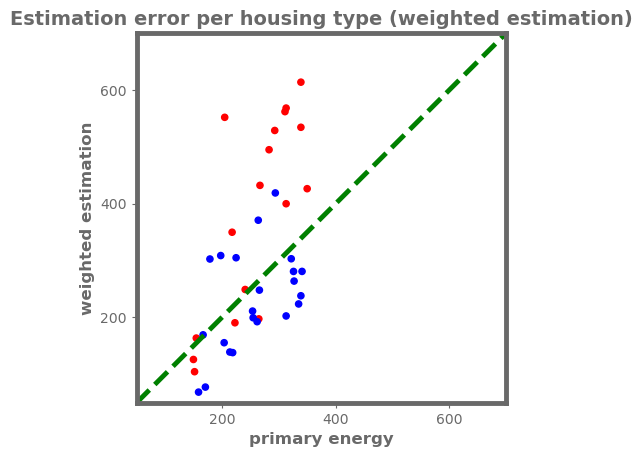

In [80]:
colors = {'Single-family': 'red', 'Multi-family': 'blue'}
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_weighted', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Housing type').map(colors), fontsize=10)
scatter.set_title('Estimation error per housing type (weighted estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('weighted estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

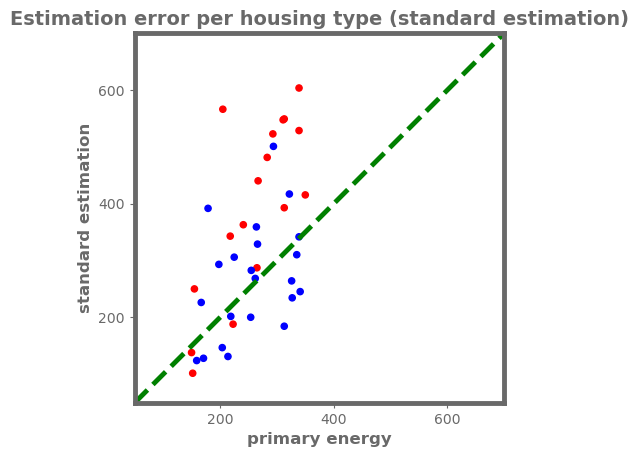

In [81]:
colors = {'Single-family': 'red', 'Multi-family': 'blue'}
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_estimated', c=buildings.index.get_level_values('Housing type').map(colors), fontsize=10)
scatter.set_title('Estimation error per housing type (standard estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('standard estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

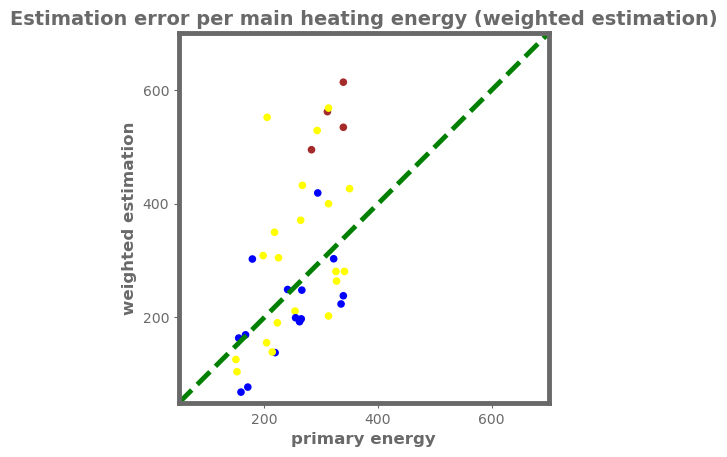

In [82]:
colors = {'Wood fuel-Standard boiler': 'brown', 'Electricity-Performance boiler': 'blue','Natural gas-Standard boiler': 'yellow', 'Natural gas-Performance boiler': 'yellow' }
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_weighted', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Heating system').map(colors), fontsize=10)
scatter.set_title('Estimation error per main heating energy (weighted estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('weighted estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

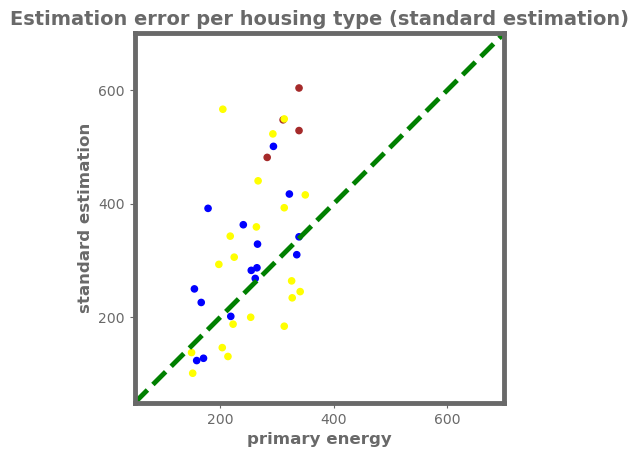

In [83]:
colors = {'Wood fuel-Standard boiler': 'brown', 'Electricity-Performance boiler': 'blue','Natural gas-Standard boiler': 'yellow', 'Natural gas-Performance boiler': 'yellow' }
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_estimated', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Heating system').map(colors), fontsize=10)
scatter.set_title('Estimation error per housing type (standard estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('standard estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

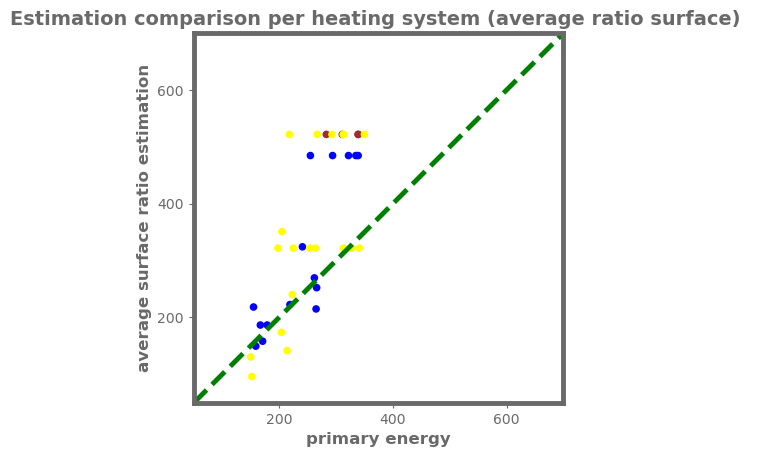

In [84]:
surface_check =  buildings.copy()
surface_check['energy_surface_estimation'] = energy_epc_surface['primary_energy_estimated']
colors = {'Wood fuel-Standard boiler': 'brown', 'Electricity-Performance boiler': 'blue','Natural gas-Standard boiler': 'yellow', 'Natural gas-Performance boiler': 'yellow' }
scatter =  surface_check.plot.scatter(x = 'primary energy', y = 'energy_surface_estimation', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Heating system').map(colors), fontsize=10)
scatter.set_title('Estimation comparison per heating system (average ratio surface) ', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('average surface ratio estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

In [58]:
estimations = buildings.copy()
estimations['av_surface_estimation'] = energy_epc_surface['primary_energy_estimated']
estimations.loc[:, ('construction period','Ratio_surface_Wall', 'Ratio_surface_Floor', 'Ratio_surface_Roof', 'Ratio_surface_Window' ,'primary energy', 'primary_energy_estimated', 'primary_energy_weighted','av_surface_estimation', 'estimation_error', 'weighted_estimation_error')]

,,,construction period,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,primary energy,primary_energy_estimated,primary_energy_weighted,av_surface_estimation,estimation_error,weighted_estimation_error
Class,Housing type,Heating system,,,,,,,,,,,
MI-1,Single-family,Wood fuel-Standard boiler,Avant 1915,1.76,0.50,0.50,0.15,311,547.496148,576.681337,529.780798,236.496148,265.681337
MI-2,Single-family,Wood fuel-Standard boiler,Avant 1915,1.33,0.50,0.85,0.13,339,528.602497,549.000267,529.780798,189.602497,210.000267
MI-3,Single-family,Wood fuel-Standard boiler,Avant 1915,0.87,0.89,1.61,0.09,339,603.496288,628.667056,529.780798,264.496288,289.667056
MI-4,Single-family,Wood fuel-Standard boiler,Avant 1915,1.25,0.67,0.67,0.13,283,481.437033,510.008683,529.780798,198.437033,227.008683
MI-5,Single-family,Natural gas-Standard boiler,1915-1945,1.45,0.51,0.80,0.18,313,549.106280,583.085008,529.780798,236.106280,270.085008
MI-6,Single-family,Natural gas-Standard boiler,1915-1945,1.06,0.35,0.55,0.24,350,415.477210,441.213741,529.780798,65.477210,91.213741
MI-7,Single-family,Natural gas-Standard boiler,1915-1945,1.02,0.50,0.50,0.15,313,392.908546,414.916863,529.780798,79.908546,101.916863
MI-8,Single-family,Natural gas-Standard boiler,1946-1968,1.55,0.55,0.55,0.21,293,522.773928,543.428556,529.780798,229.773928,250.428556
MI-9,Single-family,Natural gas-Standard boiler,1946-1968,1.22,0.50,0.50,0.20,267,440.233061,446.598514,529.780798,173.233061,179.598514


### Discussion
* Wood fueled, Single-family, before 1915 built dwellings are the most over-estimated annual energy need by all methods.
* Comparing the line LC3 to LC4: the change from gas to electricity as a main source of energy for 1915 built multi-family buildings decreases energy need, while our estimations account for a significant increases. U-values doesn't change since the construction period are the same. What changes in our estimation is the efficiency and the surface ratio. When we look at the av_surface_estimation, for which the surface ratio remain the same, the estimation still increases instead of decreasing. I conclude that it's our efficency parameter which gives this error and of course the fact we omit the parameters which causes the original decrease. Our simple weighting doesn't solve the issue.

Observed parameters:
- surface ratio: we calculate using the Res-IRF averages to test
- u values: a large part comes from the French 3CL reference values and the other when reported from profeel
- efficiency: We calculate the weighted average of the annual energy need wrt. electric or fossil fuel share of the heating system. Each fossil fuel has the same efficiency value.

#### For data_matching

In [59]:
energy_epc_std = energy_epc_std.drop(labels=['Ratio_surface_Wall', 'Ratio_surface_Floor', 'Ratio_surface_Roof','Ratio_surface_Window', 'construction period', 'EPC', 'primary energy', 'Ventilation', 'Ventilation gross', 'Electric fuel share', 'Fossil fuel share', 'Efficiency'], axis=1)

In [60]:
energy_epc_std.to_csv('output/building_stock_profeel_std.csv')